<a href="https://colab.research.google.com/github/FUenal/energy_damand_prediction/blob/main/Time_Series_Modeling_Tutorial_WIDS_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1iCBHGPpuFegJo89eRIE2SK-UbTZPMde2)




A tutorial presented at the [WIDS Geneva](https://widsgeneva.ch/) 2024 by Sabrina Amrouche, ZYTLYN Technologies.

© ZYTLYN Technologies. Apache License 2.0.

In this workshop we will :


*   Cover the basics of time series forecasting
*   Use the open source darts library to test few models
*   Boost our baselines using data and model tricks




# The Dataset


Argo Solutions - A leading technology company in Latin America provided a dataset simulating real corporate travel systems focusing on flights during a weekend long competition: [Travel Dataset - Datathon 2019](https://www.kaggle.com/competitions/tourism2/overview).

**The raw dataset is un-aggregated. In this workshop you are using the monthly aggregated data.**

You are encouraged to later explore more datasets, here few of the most famous ones for TSF benchmarking:


*   [m5-forecasting-accuracy](https://www.kaggle.com/competitions/m5-forecasting-accuracy): Estimate the unit sales of Walmart retail goods on Kaggle
*   Other M competitions, data and solutions : https://github.com/Mcompetitions



In [1]:
# Run the code below to access cloud data files from the public bucket created for this workshop
from google.colab import auth
auth.authenticate_user()

In [10]:
import pandas as pd

df=pd.read_csv("gs://travel_data_wids/flights_data.csv")
df.head()

,origin,destination,date,passengers
0,Aracaju (SE),Brasilia (DF),2019-9,45
1,Aracaju (SE),Brasilia (DF),2019-10,235
2,Aracaju (SE),Brasilia (DF),2019-11,198
3,Aracaju (SE),Brasilia (DF),2019-12,179
4,Aracaju (SE),Brasilia (DF),2020-1,197


array([[<Axes: title={'center': 'passengers'}>]], dtype=object)

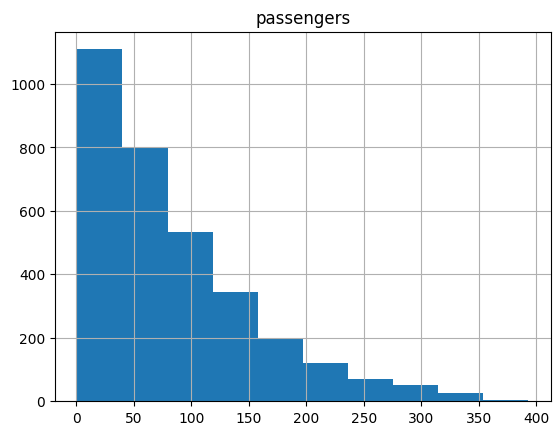

In [3]:
df.hist()

<Axes: xlabel='date'>

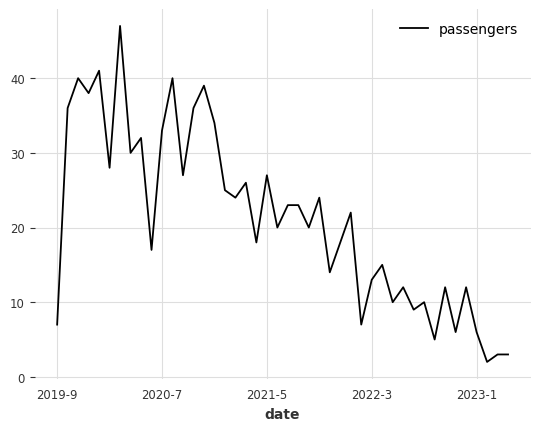

In [11]:
target_ts=df[(df.origin=="Rio de Janeiro (RJ)") & (df.destination=="Sao Paulo (SP)")]
target_ts.plot(x="date",y="passengers")

# The toolkit : Darts by Unit8

[Darts](https://github.com/unit8co/darts) is an open-source Python solution for time series forecasting and anomaly detection. As its developers put it, you can use Darts to do time series analysis and forecasting without having to worry about going through the documentation of other libraries (statsmodels, sklearn, pytorch...)

Darts is a great library if you are starting with TSF as it provides an intuitive abstraction over handy analysis tools and several interesting models.

In [5]:
# darts allows you to access a variety of ready-to-use baselines
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 k

## Quick insights

Darts provides a TimeSeries class that allows to represent univariate or multivariate series. Converting your pandas time series to this class allows access to several interesting attributes and methods that we will use later.

In [12]:
from darts import TimeSeries
series_travel=TimeSeries.from_dataframe(target_ts,"date", "passengers")
series_travel.freq, series_travel.duration, series_travel.is_univariate

(<MonthBegin>, Timedelta('1308 days 00:00:00'), True)


### In real world, time series are often irregular.
If we take a look at another time series present in the dataset, not all months are present.
When using [TimeSeries](https://unit8co.github.io/darts/generated_api/darts.timeseries.html) class from darts, it checks the inherent frequency of the data, so providing no further guidance, **the following code will fail !**

In [13]:
expl_ts=df[(df.origin=="Rio de Janeiro (RJ)") & (df.destination=="Aracaju (SE)")]
expl_ts_darts=TimeSeries.from_dataframe(expl_ts,"date", "passengers")

ERROR:darts.timeseries:ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.


ValueError: The time index of the provided DataArray is missing the freq attribute, and the frequency could not be directly inferred. This probably comes from inconsistent date frequencies with missing dates. If you know the actual frequency, try setting `fill_missing_dates=True, freq=actual_frequency`. If not, try setting `fill_missing_dates=True, freq=None` to see if a frequency can be inferred.

Offset alias are defined in pandas time series [page](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases). There are several frequencies aliases and for our use case, MS -> month start frequency will be enough

In [14]:
expl_ts_darts=TimeSeries.from_dataframe(expl_ts,"date", "passengers",fill_missing_dates=True, freq="MS")
expl_ts_darts.freq, expl_ts_darts.duration, expl_ts_darts.is_univariate

(<MonthBegin>, Timedelta('1399 days 00:00:00'), True)

### Checking Seasonality and Trend

<Axes: xlabel='date'>

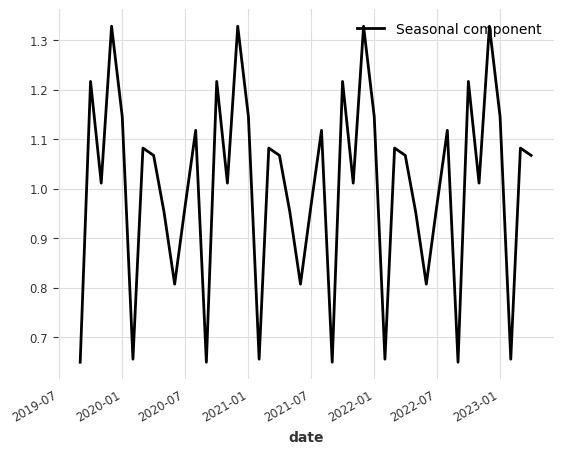

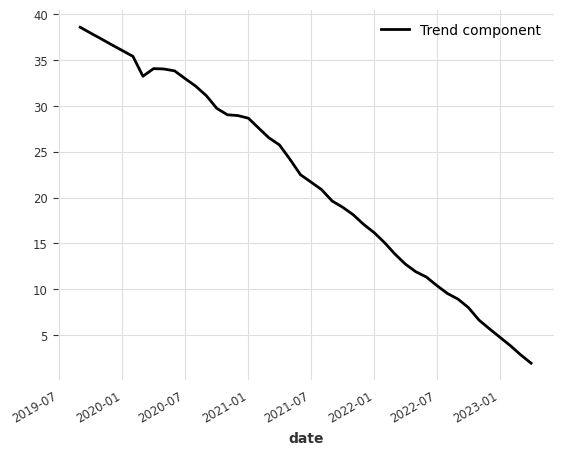

In [15]:
from darts.utils.statistics import extract_trend_and_seasonality
# decompose
trend,seasonal=extract_trend_and_seasonality(series_travel)
# plot
seasonal.plot(label="Seasonal component")
trend.plot(new_plot=True,label="Trend component")

### Exercise #1
can you do the same with statsmodels? Fill in the gaps

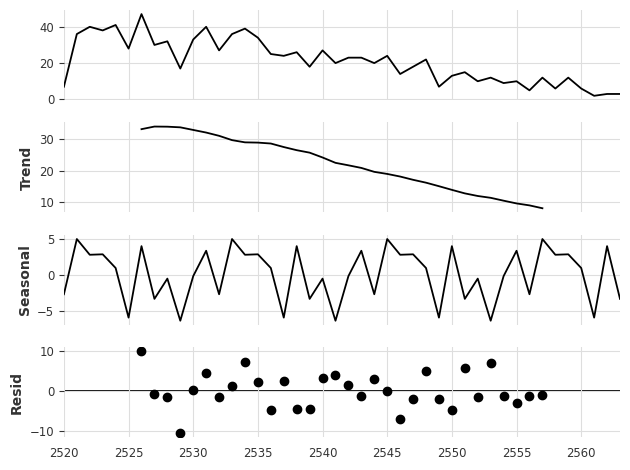

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(target_ts[["passengers"]],model="additive",period=12)

decompose_result_mult.plot();

More statistics functionalities to check out --> [darts.utils.statistics](https://unit8co.github.io/darts/generated_api/darts.utils.statistics.html)

# Forecasting

In [18]:
def am_i_done(mse_score_improv,mse_score):
  """Tell visualy if you nailed your exercice"""
  if mse_score_improv<mse_score:
    print("\033[92m\"Great Job!!\"\033[0m")
  else:
    print("\x1b[31m\"Keep going, you can do it!\"\x1b[0m")

# our prediction horizon is set here
prediction_horizon=12
# we split our data such as we have a test set of size {prediction_horizon}
train_travel, val_travel = series_travel[:-prediction_horizon], series_travel[-prediction_horizon:]

In [19]:
from darts.dataprocessing.transformers import Scaler
# Scaling is a very crutial step in our modeling
# By default, Darts scaler uses sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler = Scaler()
train_travel_scaled = scaler.fit_transform(train_travel)
val_travel_scaled = scaler.transform(val_travel)


## A simple Linear Regression

<Axes: xlabel='date'>

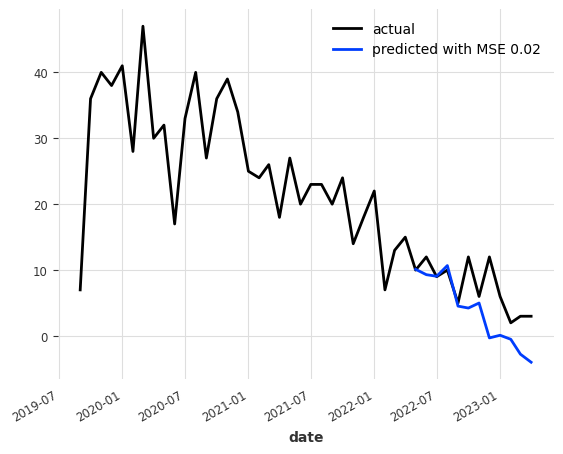

In [20]:
from darts.models import LinearRegressionModel
from darts.metrics import  mse

# Define a model
model = LinearRegressionModel(
    lags=12,
)
# Train it
model.fit(train_travel_scaled)
# Generate predictions
model_predictions=model.predict(series=train_travel_scaled,n=prediction_horizon)
scaled_back_predictions=scaler.inverse_transform(model_predictions)

mse_score=round(mse(val_travel_scaled,model_predictions),2)

series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"predicted with MSE {mse_score}")

## Exercise #2

Can you make this model better? Fill in the gaps

**Hint:** have a look at what the [LinearRegressionModel](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.linear_regression_model.html) can take as parameters.

`linear_regression_model.LinearRegressionModel(lags=None, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, .... )`

In [ ]:
model = LinearRegressionModel(
    lags=12,
    #some_awesome_feature_here=...,
    #some_other_awesome_feature_here=...,
  )
model.fit(train_travel_scaled)
# Generate predictions
model_predictions=model.predict(series=train_travel_scaled,n=prediction_horizon)
scaled_back_predictions=scaler.inverse_transform(model_predictions)

mse_score_improv=round(mse(val_travel_scaled,model_predictions),2)
am_i_done(mse_score_improv,mse_score)

series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"predicted {mse_score_improv}")

"Great Job!!"


<Axes: xlabel='date'>

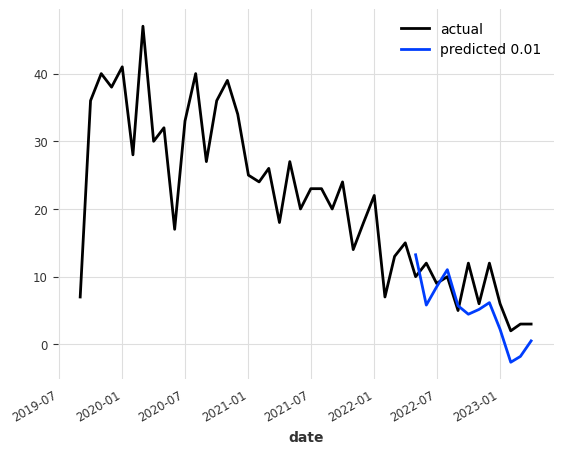

In [21]:
# @title Solution
# Are you done trying?
# Sure, sure?
# ok..
# try this model then
# Darts Encoders: using covariates for free -> deep learning models in Darts have a built-in functionality to use such covariates out of the box.
model = LinearRegressionModel(
    lags=12,
    lags_future_covariates=(12,36),
    add_encoders={
       "cyclic": {"future": [ "weekofyear"]}, #This reads : The weekofyear should be used as a future covariate, with a cyclic (sin/cos) encoding.
    },
)

model.fit(train_travel_scaled)
# Generate predictions
model_predictions=model.predict(series=train_travel_scaled,n=prediction_horizon)
scaled_back_predictions=scaler.inverse_transform(model_predictions)

mse_score_improv=round(mse(val_travel_scaled,model_predictions),2)
am_i_done(mse_score_improv,mse_score)
series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"predicted {mse_score_improv}")

## Facebook Prophet
[Prophet](https://facebook.github.io/prophet/) is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2i9h8xeq/z1k2fd6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2i9h8xeq/pj21vh6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76660', 'data', 'file=/tmp/tmp2i9h8xeq/z1k2fd6f.json', 'init=/tmp/tmp2i9h8xeq/pj21vh6n.json', 'output', 'file=/tmp/tmp2i9h8xeq/prophet_modelkdnmdr_s/prophet_model-20240308153920.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:39:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:

<Axes: xlabel='date'>

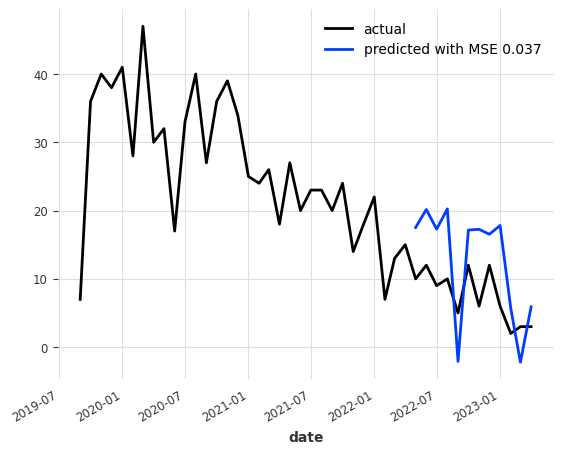

In [22]:
from darts.models import Prophet
model=Prophet()
model.fit(train_travel_scaled)
model_predictions= model.predict(prediction_horizon)
mse_score=round(mse(val_travel_scaled,model_predictions),3)

scaled_back_predictions=scaler.inverse_transform(model_predictions)
series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"predicted with MSE {mse_score}")


## Exercise #3
Same as before, try figuring out where the model could be helped a bit

In [ ]:
#model=Prophet(cool_feature={
#    'cool_sub_feature1': {'future': ...},
#    'cool_sub_feature2': ...,
#    ...,
#    })

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2i9h8xeq/0ch_ft_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2i9h8xeq/vjk7wksn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97841', 'data', 'file=/tmp/tmp2i9h8xeq/0ch_ft_z.json', 'init=/tmp/tmp2i9h8xeq/vjk7wksn.json', 'output', 'file=/tmp/tmp2i9h8xeq/prophet_model89ppr_5v/prophet_model-20240308154105.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:41:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:41:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:

<Axes: xlabel='date'>

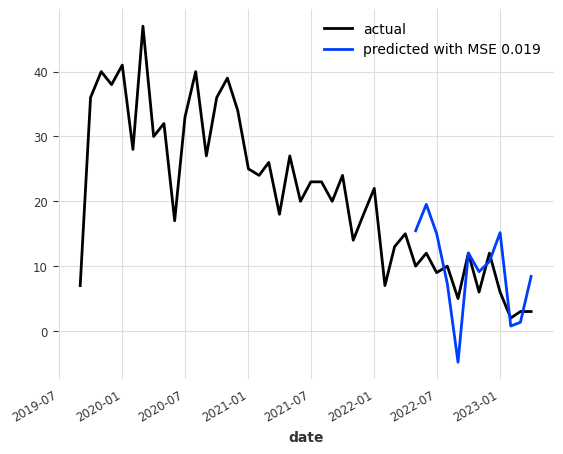

In [23]:
# @title Solution
#A large number of future covariates can be automatically generated with add_encoders.

model=Prophet(add_seasonalities={
        'name':"monthly_seasonality",
        'seasonal_periods':4,
        'fourier_order':5
        },country_holidays="BR") # checkout https://github.com/dr-prodigy/python-holidays
model.fit(train_travel_scaled)
model_predictions= model.predict(prediction_horizon)
mse_score=round(mse(val_travel_scaled,model_predictions),3)

scaled_back_predictions=scaler.inverse_transform(model_predictions)
series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"predicted with MSE {mse_score}")

## Moving on to Neural Nets
[N-BEATS](https://arxiv.org/abs/1905.10437) Time-Series Forecasting with Neural Basis Expansion.


![](https://user-images.githubusercontent.com/49645682/129486828-0afa279c-7874-4e39-89e5-c40fbf7a0a80.png)






INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.6 M 
---------------------------------------------------
1.6 M     Trainable params
6.0 K     Non-trainable params
1.6 M     Total params
6.416     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:383: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

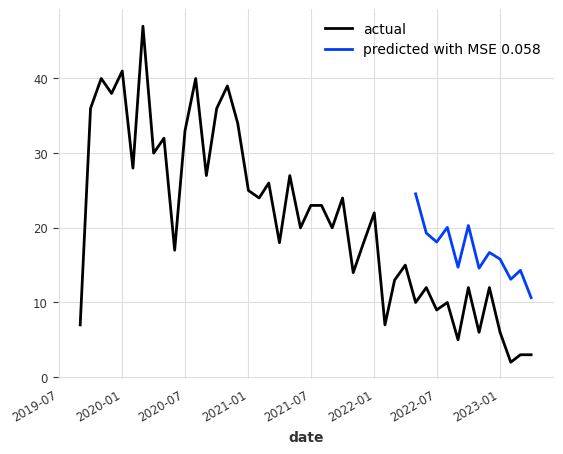

In [24]:
from darts.models import NBEATSModel
from darts.metrics import  mse

model_name="travel_model"
model=NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=prediction_horizon,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
)

model.fit(train_travel_scaled, epochs=50, verbose=True)
model_predictions=model.predict(series=train_travel_scaled,n=prediction_horizon)


mse_score=round(mse(val_travel_scaled,model_predictions),3)


scaled_back_predictions=scaler.inverse_transform(model_predictions)
series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"predicted with MSE {mse_score}")



### A global N-BEATS

In [ ]:
def get_scaled_training_set(df):
  train_ts=[]
  groups=df.groupby(["origin","destination"])
  for k,od_df in groups:
      ts=TimeSeries.from_dataframe(od_df,"date", "passengers",fill_missing_dates=True, freq="MS")
      scaler = Scaler()
      train_ts.append(scaler.fit_transform(ts[:-prediction_horizon]))
  return train_ts

In [ ]:
train_ts=get_scaled_training_set(df)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.6 M 
---------------------------------------------------
1.6 M     Trainable params
6.0 K     Non-trainable params
1.6 M     Total params
6.416     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

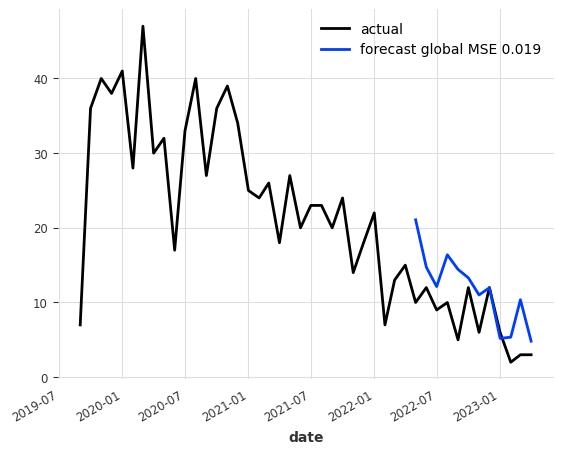

In [ ]:
from darts.models import NBEATSModel
from darts.metrics import  mse

model=NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=prediction_horizon,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    nr_epochs_val_period=1,
    random_state=42)
model.fit(train_ts, epochs=50, verbose=True)

model_predictions=model.predict(series=train_travel_scaled,n=prediction_horizon)

mse_score=round(mse(val_travel_scaled,model_predictions),3)


scaled_back_predictions=scaler.inverse_transform(model_predictions)
# Plotting
series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"forecast global MSE {mse_score}")

## Exercise #4
can we do better ? What would we need to do better to improve our forecasting accuracy for Rio de Janeiro (RJ) to Aracaju (SE) ?

In [ ]:
# Fill the gaps
def get_scaled_training_set_improved(df):
  train_ts=[]
  # add few lines here to help the model focus even mpre
  # df=
  groups=df.groupby(["origin","destination"])
  for k,od_df in groups:
      ts=TimeSeries.from_dataframe(od_df,"date", "passengers",fill_missing_dates=True, freq="MS")
      scaler = Scaler()
      train_ts.append(scaler.fit_transform(ts[:-prediction_horizon]))
  return train_ts

In [ ]:
# @title Test your code
train_ts=get_scaled_training_set_improved(df)

model=NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=prediction_horizon,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    nr_epochs_val_period=1,
    random_state=42)
model.fit(train_ts, epochs=50, verbose=True)

model_predictions=model.predict(series=train_travel_scaled,n=prediction_horizon)

mse_score_improv=round(mse(val_travel_scaled,model_predictions),3)
am_i_done(mse_score_improv,mse_score)

scaled_back_predictions=scaler.inverse_transform(model_predictions)
# Plotting
series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"forecast global MSE {mse_score}")

# A better loss

In [ ]:
import torch
def weighted_forecast_horizon_loss(y_pred,y_true,business_constraint=[3,9]):
      # Calculate squared error
      squared_error = (y_pred - y_true) ** 2
      horizon_weights = torch.full((prediction_horizon,), 1.0, dtype=torch.float32)
      large_weight=3
      horizon_weights[business_constraint] = large_weight

      # Apply horizon weights
      weighted_error = squared_error * horizon_weights
      loss = torch.mean(weighted_error)
      return loss

In [ ]:
model=NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=prediction_horizon,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    nr_epochs_val_period=1,
    random_state=42,loss_fn=weighted_forecast_horizon_loss)
model.fit(train_ts, epochs=5, verbose=True)

model_predictions=model.predict(series=train_travel_scaled,n=prediction_horizon)

mse_score=round(mse(val_travel_scaled,model_predictions),3)


scaled_back_predictions=scaler.inverse_transform(model_predictions)
# Plotting
series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"forecast global MSE {mse_score}")

# Future Directions



*   Moving on from MSE

  *   Look at Mean Absolute Scaled Error ([MASE](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)) and its varient [RMSSE](https://www.sciencedirect.com/science/article/pii/S0169207021001874) and OWA (overall weighted average) used during M4 competition


*   Point Forecast is incomplete without uncertainty estimation

  *   [Probabilistic forecasting](https://github.com/unit8co/darts#forecasting-models)
  *  You can easily try it with the N-BEATS using the below code

*   Uncertainty estimation
*   Ensembling


In [ ]:
# @title Probabilistic Forecasting
from darts.utils.likelihood_models import LaplaceLikelihood,QuantileRegression
model=NBEATSModel(
    input_chunk_length=12,
    output_chunk_length=prediction_horizon,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    nr_epochs_val_period=1,
    random_state=42,loss_fn=weighted_forecast_horizon_loss,likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]))
model.fit(train_ts, epochs=50, verbose=True)

model_predictions=model.predict(series=train_travel_scaled,n=prediction_horizon,num_samples=500)

mse_score=round(mse(val_travel_scaled,model_predictions),3)


scaled_back_predictions=scaler.inverse_transform(model_predictions)
# Plotting
series_travel.plot(label="actual")
scaled_back_predictions.plot(label=f"forecast global MSE {mse_score}")